<a href="https://www.kaggle.com/code/fotimakhongulomova/dogs-vs-cats?scriptVersionId=159993811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
%%capture --no-display
!pip install tensorflow
import warnings
warnings.filterwarnings('ignore')

# Notebook Imports

In [2]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Unzipping Files from train.zip, test.zip

In [3]:
os.makedirs('/kaggle/working/train')
os.makedirs('/kaggle/working/test')

In [4]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [5]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/train.zip -d /kaggle/working/train

In [6]:
cd /kaggle/input/dogs-vs-cats

/kaggle/input/dogs-vs-cats


In [7]:
%%capture --no-display
!unzip /kaggle/input/dogs-vs-cats/test1.zip -d /kaggle/working/test

In [8]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available 1


### Data Preparation

In [9]:
# Organize data into train, valid, test dirs
os.chdir('/kaggle/working/')

if os.path.isdir('train_set/dog') is False:
    os.makedirs('train_set/dog')
    os.makedirs('train_set/cat')
    os.makedirs('valid_set/dog')
    os.makedirs('valid_set/cat')
    os.makedirs('test_set/cat')
    os.makedirs('test_set/dog')
    
try:
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 500):
        shutil.move(c, 'train_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 500):
        shutil.move(c, 'train_set/dog')
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 100):
        shutil.move(c, 'valid_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 100):
        shutil.move(c, 'valid_set/dog')
    for c in random.sample(glob.glob('/kaggle/working/train/train/cat.*'), 50):
        shutil.move(c, 'test_set/cat')
    for c in random.sample(glob.glob('/kaggle/working/train/train/dog.*'), 50):
        shutil.move(c, 'test_set/dog')

except Exception as e:
    print(f"An error occurred: {e}")

os.chdir('../..')

In [10]:
train_set_path = "/kaggle/working/train_set"
test_set_path = "/kaggle/working/test_set"
valid_set_path = "/kaggle/working/valid_set"

In [11]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_set_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [12]:
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100

In [13]:
imgs, labels = next(train_batches)

In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

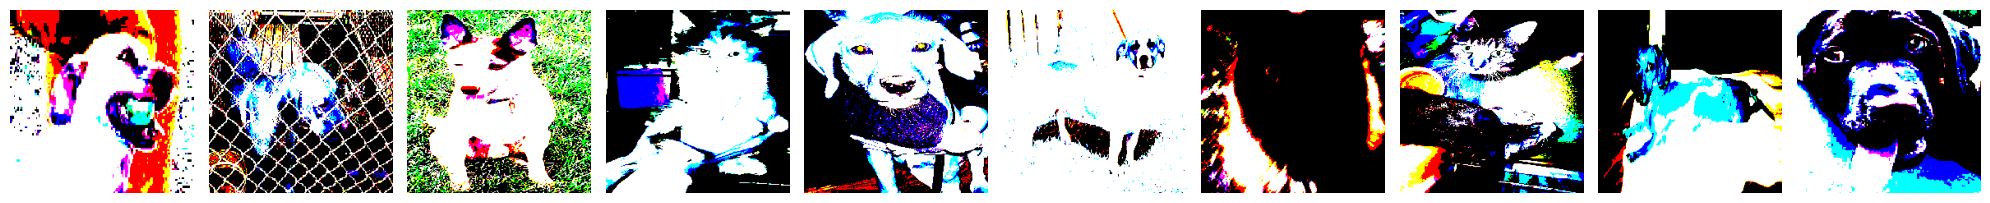

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [15]:
plotImages(imgs)
print(labels)

## Build and Train a CNN

In [16]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [18]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
100/100 - 7s - loss: 31.0547 - accuracy: 0.5510 - val_loss: 18.6922 - val_accuracy: 0.6200 - 7s/epoch - 66ms/step
Epoch 2/10
100/100 - 3s - loss: 12.6197 - accuracy: 0.7070 - val_loss: 10.6616 - val_accuracy: 0.6450 - 3s/epoch - 29ms/step
Epoch 3/10
100/100 - 3s - loss: 6.5703 - accuracy: 0.7740 - val_loss: 13.6282 - val_accuracy: 0.6200 - 3s/epoch - 29ms/step
Epoch 4/10
100/100 - 3s - loss: 2.3856 - accuracy: 0.8790 - val_loss: 11.0939 - val_accuracy: 0.6250 - 3s/epoch - 29ms/step
Epoch 5/10
100/100 - 3s - loss: 1.2550 - accuracy: 0.9200 - val_loss: 10.3986 - val_accuracy: 0.6050 - 3s/epoch - 30ms/step
Epoch 6/10
100/100 - 3s - loss: 1.1597 - accuracy: 0.9180 - val_loss: 11.6125 - val_accuracy: 0.5750 - 3s/epoch - 29ms/step
Epoch 7/10
100/100 - 3s - loss: 1.5832 - accuracy: 0.9250 - val_loss: 12.1446 - val_accuracy: 0.6300 - 3s/epoch - 28ms/step
Epoch 8/10
100/100 - 3s - loss: 0.4889 - accuracy: 0.9570 - val_loss: 10.4340 - val_accuracy: 0.6100 - 3s/epoch - 29ms/step
Epoch 

## Predict

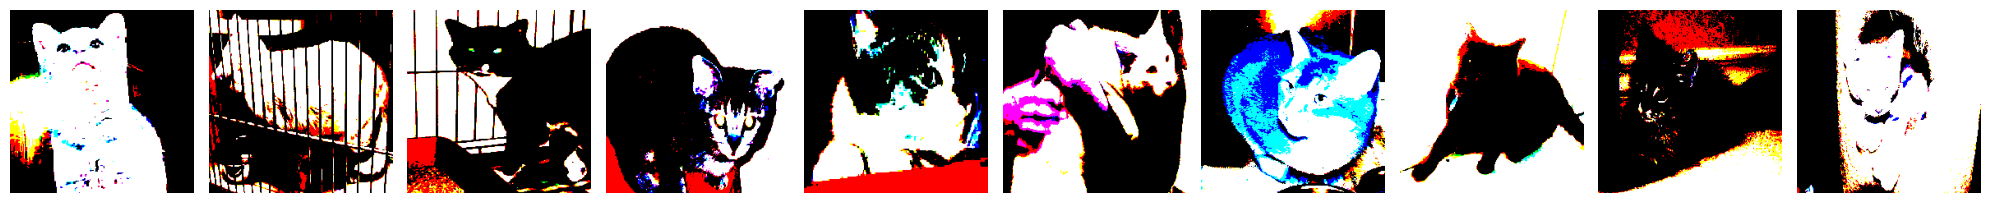

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [20]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [21]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [22]:
predictions = model.predict(x=test_batches, verbose=0)

In [23]:
np.round(predictions)

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.

In [24]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
labels = ['cat', 'dog']

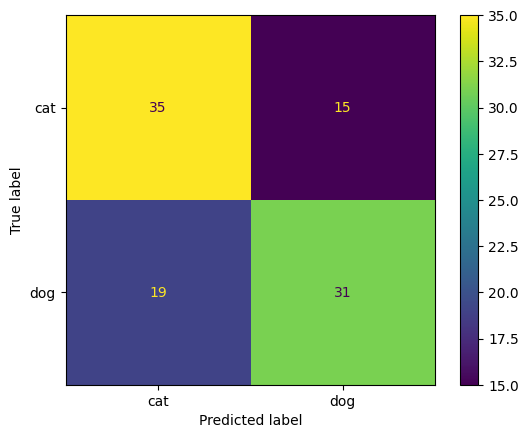

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
plt.show()